# Client

I've included the example image client here(you'll need the densenet_onnx from the Triton repo to run it) but hopefully this will serve as a solid baseline for building up our client structure.

In [1]:
!pip install tritonclient[all]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 14.8 MB 12.0 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.3.1 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
sleap 1.1.3 requires numpy<1.19.0,>=1.18.1, but you have numpy 1.19.5 which is incompatible.


In [2]:
from triton_utils import parse_model
from triton_utils import UserData
from triton_utils import requestGenerator

import numpy as np
import cv2
import tensorflow as tf
import tritonclient.grpc as grpcclient

In [3]:
def read_frames(video_path, fidxs=None, grayscale=True):
    """Read frames from a video file.
    
    Args:
        video_path: Path to MP4
        fidxs: List of frame indices or None to read all frames (default: None)
        grayscale: Keep only one channel of the images (default: True)
    
    Returns:
        Loaded images in array of shape (n_frames, height, width, channels) and dtype uint8.
    """
    vr = cv2.VideoCapture(video_path)
    if fidxs is None:
        fidxs = np.arange(vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for fidx in fidxs:
        vr.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        img = vr.read()[1]
        if grayscale:
            img = img[:, :, [0]]
        frames.append(img)
    return np.stack(frames, axis=0)

In [4]:
test_data = "../tensorrt/data/190719_090330_wt_18159206_rig1.2@15000-17560.mp4"
image_data = read_frames(test_data,np.arange(16)).astype('float32')


In [5]:
# Resize depending on the model we're actually going to use -- full for bu, 0.5 scale for centroid
image_data = tf.image.resize(image_data,size=(512,512)).numpy()

In [6]:

url = 'localhost:8001'
model_name = "centroid_savedmodel"
model_version="1"
protocol = 'grpc'
triton_client = grpcclient.InferenceServerClient(
                url=url)

In [7]:
model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)

model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

model_config = model_config.config

max_batch_size, input_name, output_name, c, h, w, format, dtype = parse_model(model_metadata, model_config)

# Fix output names for when we have multiple
output_names = [model.name for model in model_metadata.outputs]

In [8]:
requests = []
responses = []
result_filenames = []
request_ids = []
image_idx = 0
last_request = False
user_data = UserData()

sent_count = 0

In [9]:
# Pair request generator 
for inputs, outputs,model_name, model_version in requestGenerator(
        image_data, input_name, output_names, dtype, protocol,model_name,model_version):
    sent_count += 1
    responses.append(triton_client.infer(model_name,
                                inputs,
                                request_id=str(sent_count),
                                model_version=model_version,
                                outputs=outputs))

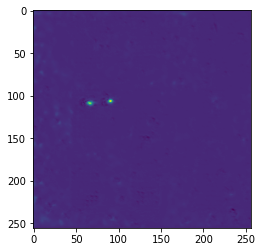

In [10]:
import matplotlib.pyplot as plt

plt.imshow(responses[0].as_numpy(output_names[0])[15])